# GPT Training from Scratch

This notebook demonstrates training a GPT-style language model from scratch on a text corpus. It covers:

- **Data loading & preprocessing**: Loading text, tokenization, train/validation split
- **Model training**: Training the 124M parameter GPT model with AdamW
- **Text generation**: Greedy and stochastic sampling (temperature, top-k)
- **Checkpointing**: Saving and loading model weights

## Setup

Add project root directory to Python path so project modules can be imported.

In [10]:
import sys
import os

# Add project root directory to Python path
sys.path.append(os.path.abspath(".."))

## Imports

Import PyTorch, tiktoken, matplotlib, and project modules (config, gpt, dataset, utils, pretrained).

In [11]:
import torch
import tiktoken
import matplotlib.pyplot as plt
from llm.config import GPT_CONFIG_124M
from llm.gpt import *
from llm.dataset import *
from llm.utils import *
from llm.pretrained import *

## Device

Set device to CPU initially; will be overridden to CUDA or MPS if available.

In [12]:
# Device for initial setup; overridden to CUDA/MPS if available later
device = "cpu"

## Load Text Dataset

Load text from the-verdict.txt, tokenize with GPT-2 BPE, and split 90% train / 10% validation by character position.

In [13]:
# ============================================================
# Load Text Dataset
# ============================================================

tokenizer = tiktoken.get_encoding("gpt2")

file_path = "train_gpt_data/the-verdict.txt"

with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

## Create DataLoaders

Create train and validation DataLoaders with `create_dataloader_v1`: sliding-window chunks of `context_length` tokens, stride equal to max_length (no overlap).

In [14]:
# ============================================================
# Create DataLoaders
# ============================================================

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

## Initialize Model

Select best available device (CUDA, MPS, or CPU), instantiate GPT-2 124M, and move model to device.

In [15]:
# ============================================================
# Initialize Model
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

Using device: cpu


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Initial Loss Evaluation

Compute train and validation loss on the untrained model as a baseline.

In [16]:
# ============================================================
# Initial Loss Evaluation
# ============================================================

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.99092928568522
Validation loss: 10.982184410095215


## Training

Train the model with AdamW. Logs train/val loss and generates sample text at evaluation intervals.

In [17]:
# ============================================================
# Training
# ============================================================

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1
)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.869, Val loss 10.071
Ep 1 (Step 000005): Train loss 8.041, Val loss 8.311
Every effort moves you, the, the, the, the,, the, the, the,,, the,,,,,,, the,, the,, the,,,,,,,,,,, the,,,,,
Ep 2 (Step 000010): Train loss 6.776, Val loss 7.059
Ep 2 (Step 000015): Train loss 6.105, Val loss 6.613
Every effort moves you, the, the the the, the, the, the, the.                                   
Ep 3 (Step 000020): Train loss 5.745, Val loss 6.598
Ep 3 (Step 000025): Train loss 5.701, Val loss 6.574
Every effort moves you.                                                 
Ep 4 (Step 000030): Train loss 5.468, Val loss 6.474
Ep 4 (Step 000035): Train loss 5.295, Val loss 6.506
Every effort moves you.                                                 
Ep 5 (Step 000040): Train loss 5.079, Val loss 6.447
Every effort moves you.   "I to" to the picture to the picture.               ", I had been, and I had been, and, I had been, I had been
Ep 6 (Step 000045): Train loss 4.

## Plot Training Curve

Plot train and validation loss vs epochs and tokens seen.

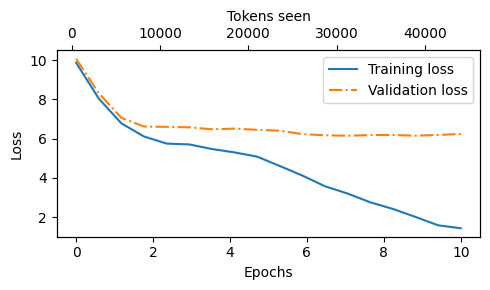

<Figure size 640x480 with 0 Axes>

In [33]:
# ============================================================
# Plot Training Curve
# ============================================================

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.savefig("train_gpt_images/loss-plot.pdf")


## Text Generation (Greedy)

Generate text with `generate_text_simple`: greedy decoding (argmax) picks the most likely next token at each step.

In [19]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()


tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=25,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisburn, I


## Sampling Demonstrations

Softmax and argmax: convert logits to probabilities and pick the most likely next token (greedy).

In [20]:
# ============================================================
# Softmax Demonstration (Toy Example)
# ============================================================

vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


## Stochastic Sampling and Temperature

Multinomial sampling from logits; temperature scaling to sharpen or soften the distribution; visualize sampling frequencies and temperature effects.

forward
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


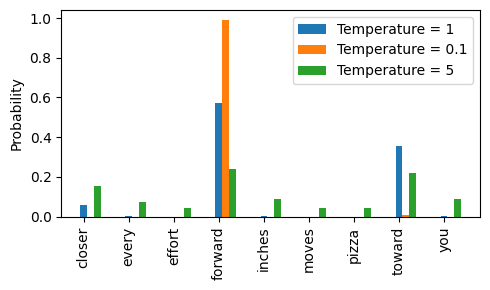

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


In [32]:
# ============================================================
# Stochastic Sampling (Multinomial)
# ============================================================

torch.manual_seed(123)

next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])


# ------------------------------------------------------------
# Sampling Distribution Visualization
# ------------------------------------------------------------

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)


# ============================================================
# Temperature Scaling
# ============================================================

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]

scaled_probas = [
    softmax_with_temperature(next_token_logits, T)
    for T in temperatures
]


# ------------------------------------------------------------
# Plot Temperature Effects
# ------------------------------------------------------------

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))

for i, T in enumerate(temperatures):
    rects = ax.bar(
        x + i * bar_width,
        scaled_probas[i],
        bar_width,
        label=f"Temperature = {T}"
    )

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("train_gpt_images/temperature-plot.pdf")
plt.show()


# ------------------------------------------------------------
# Sampling After Temperature Scaling
# ------------------------------------------------------------

print_sampled_tokens(scaled_probas[1])

print()
print_sampled_tokens(scaled_probas[2])

## Top-K Sampling Demo

Select top-k logits, mask the rest with -inf, apply softmax to get a probability distribution over the top-k tokens.

In [22]:
# ============================================================
# Top-K Sampling
# ============================================================

top_k = 3

# Select top-k logits and their positions
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)


# ------------------------------------------------------------
# Mask out everything except top-k tokens
# ------------------------------------------------------------

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)


# ------------------------------------------------------------
# Convert masked logits to probabilities
# ------------------------------------------------------------

topk_probas = torch.softmax(new_logits, dim=0)

print(topk_probas)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Generate Text with Top-K and Temperature

Use `generate()` with top_k=25 and temperature=1.4 for stochastic (non-greedy) text generation.

In [23]:
# ============================================================
# Advanced Generation with Top-K and Temperature
# ============================================================

torch.manual_seed(123)

inference_device = torch.device("cpu")

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand," was not surprise. It is to have been an object for enough


## Save Model

Save trained model weights to model.pth.

In [30]:
# ============================================================
# Save Model Weights
# ============================================================

torch.save(model.state_dict(), "train_gpt_model_weights/model.pth")
print("Model saved as model.pth")

Model saved as model.pth


## Load Model

Load saved weights into a new GPT model instance.

In [31]:
# ============================================================
# Reload Saved Model Weights
# ============================================================

model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

model.load_state_dict(
    torch.load("train_gpt_model_weights/model.pth", map_location=device, weights_only=True)
)

model.eval()


# ============================================================
# Save Full Checkpoint (Model + Optimizer)
# ============================================================

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "train_gpt_model_weights/model_and_optimizer.pth"
)


# ============================================================
# Reload Full Checkpoint
# ============================================================

checkpoint = torch.load("train_gpt_model_weights/model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0005,
    weight_decay=0.1
)

optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

model.train()

Device: cpu


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features